# Task 1

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# file_path = '/content/drive/.shortcut-targets-by-id/1vkknCL6OjwZzWbtKB-zBXYSXEFQyKkjV/stats m148/dat_train1.csv'
file_path = 'dat_train1.csv'

df = pd.read_csv(file_path)
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])

# define a duplicate as same user, same action, same time
duplicate_mask = df.duplicated(subset=['customer_id', 'event_name', 'event_timestamp'], keep='first')
num_duplicates = duplicate_mask.sum()
total_rows_before = len(df)
proportion_duplicates = num_duplicates / total_rows_before

# remove duplicates
df_clean = df[~duplicate_mask].copy()
total_rows_after = len(df_clean)

# fix action counter (journey_steps_until_end)
# sort by customer and time, then group by customer to re-assign the step numbers
df_clean = df_clean.sort_values(by=['customer_id', 'event_timestamp'])
df_clean['journey_steps_until_end'] = df_clean.groupby('customer_id').cumcount() + 1

# 1. Filter for successful orders only
# df_clean is the dataframe after removing duplicates in Task 2
df_orders = df_clean[df_clean['event_name'] == 'order_shipped'].copy()

# Ensure the timestamp is in datetime format
df_orders['event_timestamp'] = pd.to_datetime(df_orders['event_timestamp'])

# Cut off data so it starts in Feb 2021 (data providers mentioned the first little stretch is inaccurate)
df_orders = df_orders[df_orders['event_timestamp'] >= '2021-02-01'].copy()

18:06:39 - cmdstanpy - INFO - Chain [1] start processing
18:06:39 - cmdstanpy - INFO - Chain [1] done processing


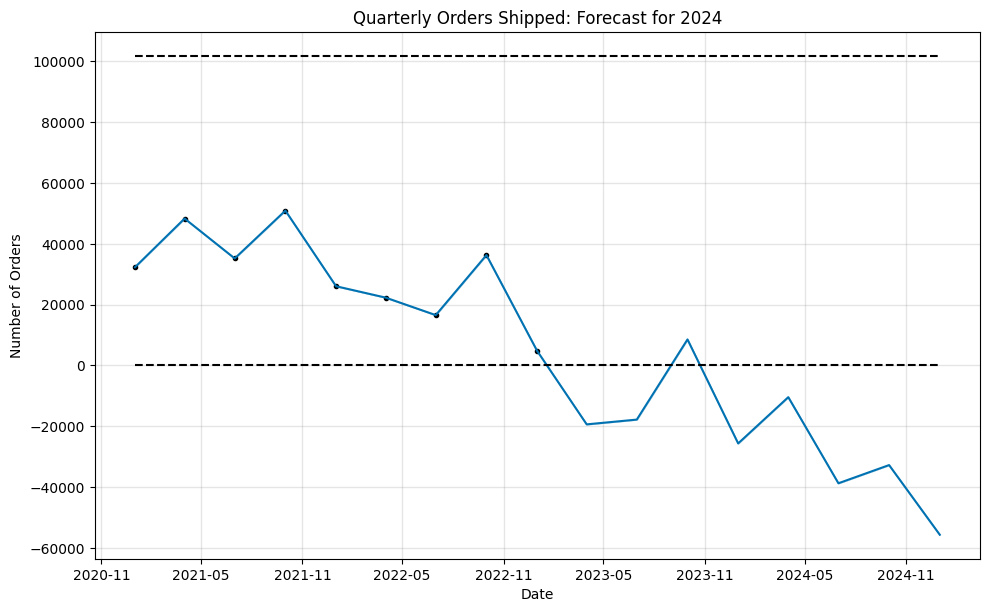

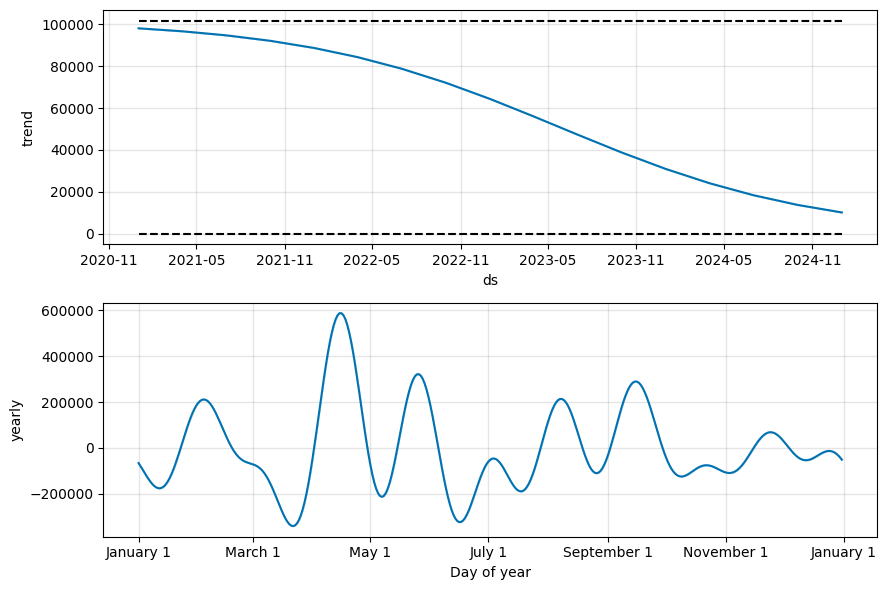

In [3]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap
m = Prophet(growth='logistic')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing


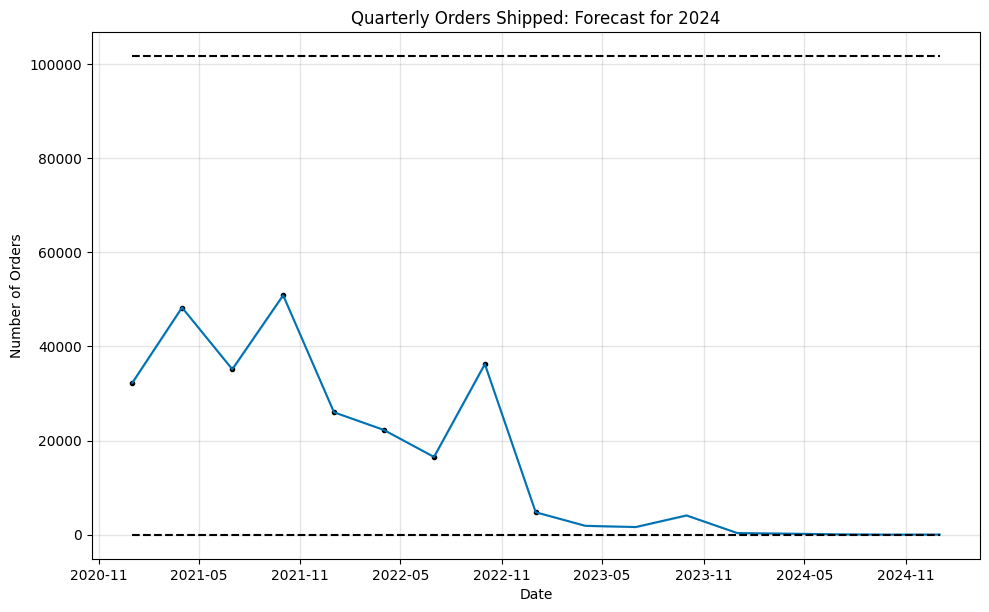

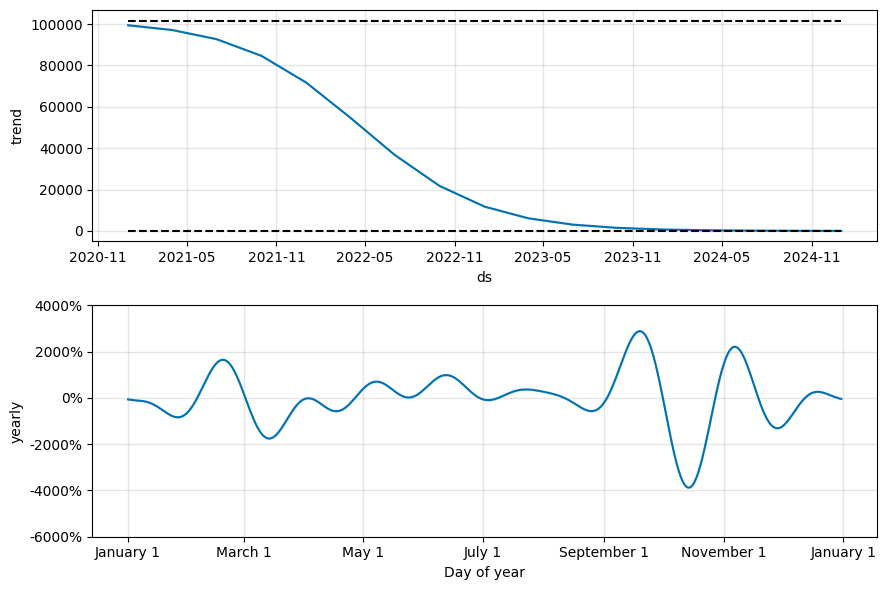

In [4]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to 0 to prevent negative predictions
quarterly_series['floor'] = 0
# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth AND multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = 0
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray negative predictions in the main forecast and lower confidence interval to be 0
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing


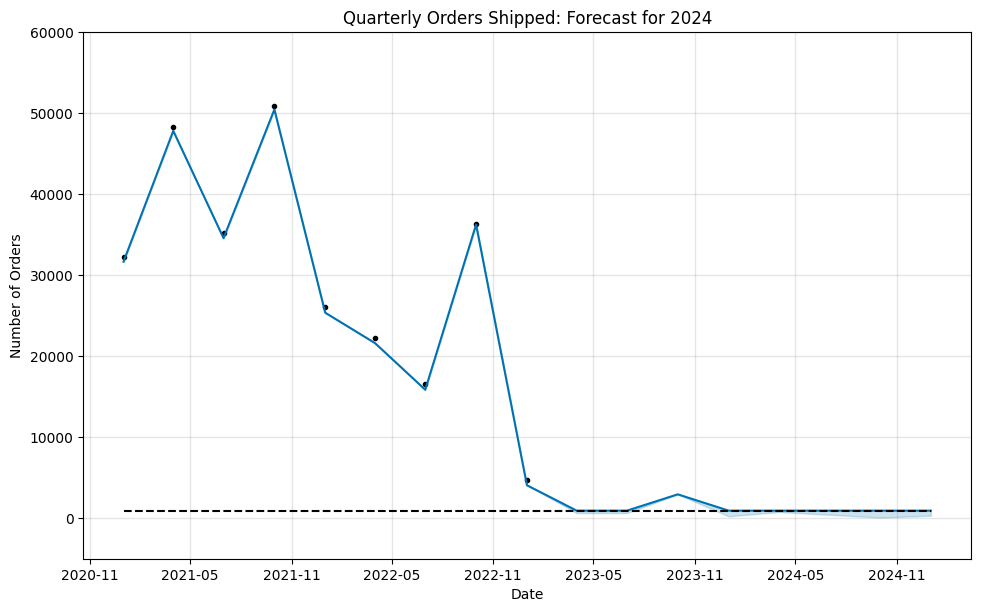

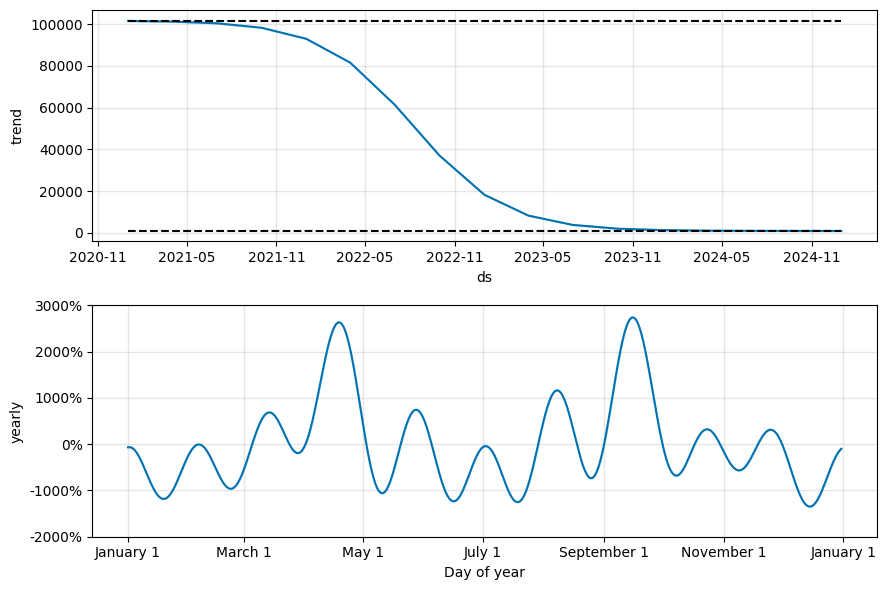

In [9]:
# 2. Resample to Quarter Start (QS) to get quarterly aggregate of orders
quarterly_series = df_orders.resample('QS', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
quarterly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
quarterly_series['ds'] = quarterly_series['ds'].dt.tz_localize(None)

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = quarterly_series['y'].mean() * 0.03
quarterly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = quarterly_series['y'].max()
quarterly_series['cap'] = max_orders * 2

# 3. Fit the model using logistic growth to enforce the floor and cap, and multiplicative seasonality
m = Prophet(growth='logistic', seasonality_mode='multiplicative')
m.fit(quarterly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 8 quarters into the future
future = m.make_future_dataframe(periods=8, freq='QS')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Quarterly Orders Shipped: Forecast for 2024')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.ylim(top = 60000)
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing


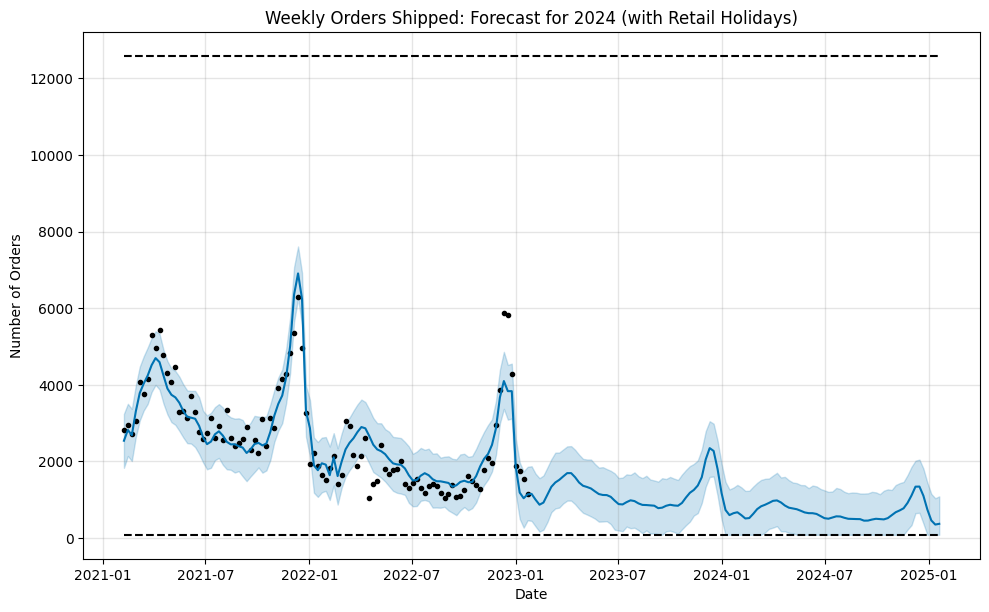

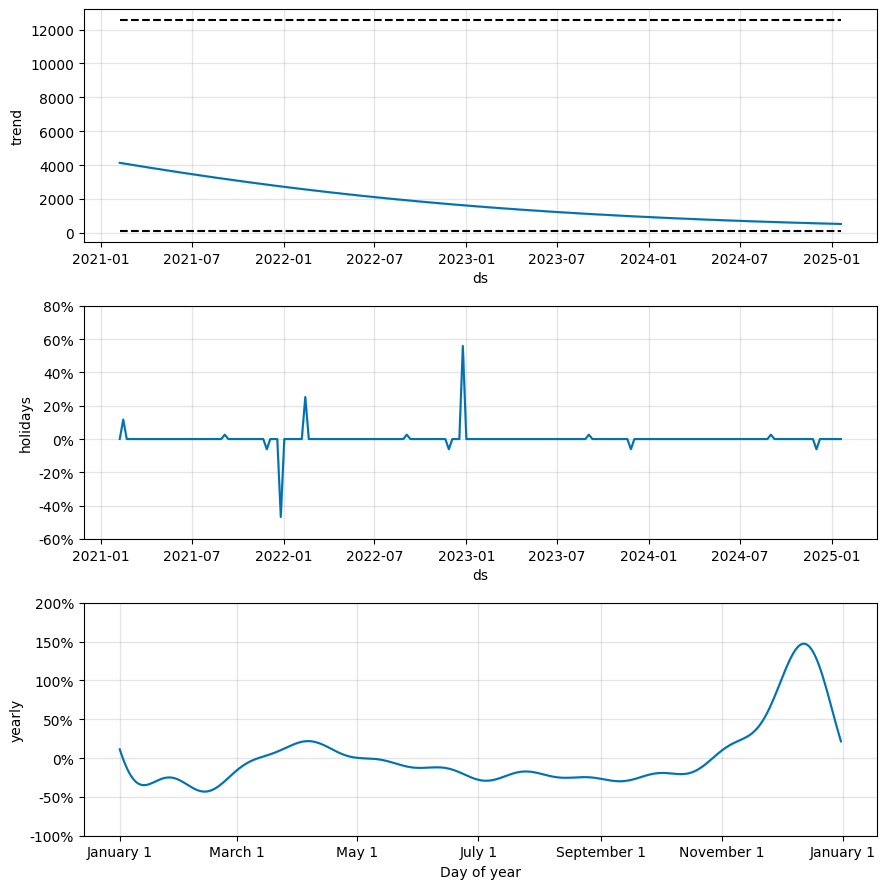

In [17]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, multiplicative seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='multiplicative', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (with Retail Holidays)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

20:37:18 - cmdstanpy - INFO - Chain [1] start processing
20:37:18 - cmdstanpy - INFO - Chain [1] done processing


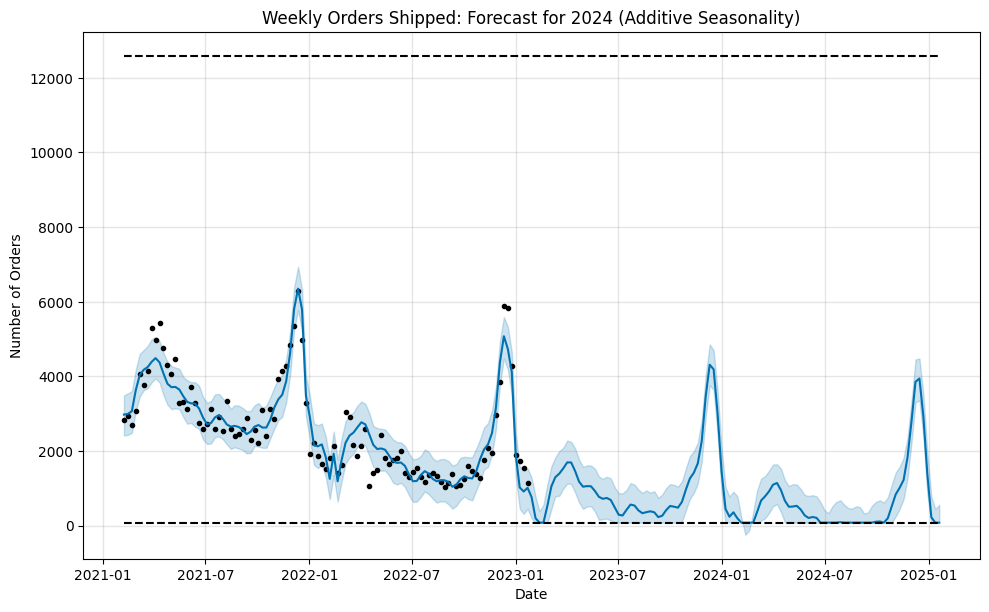

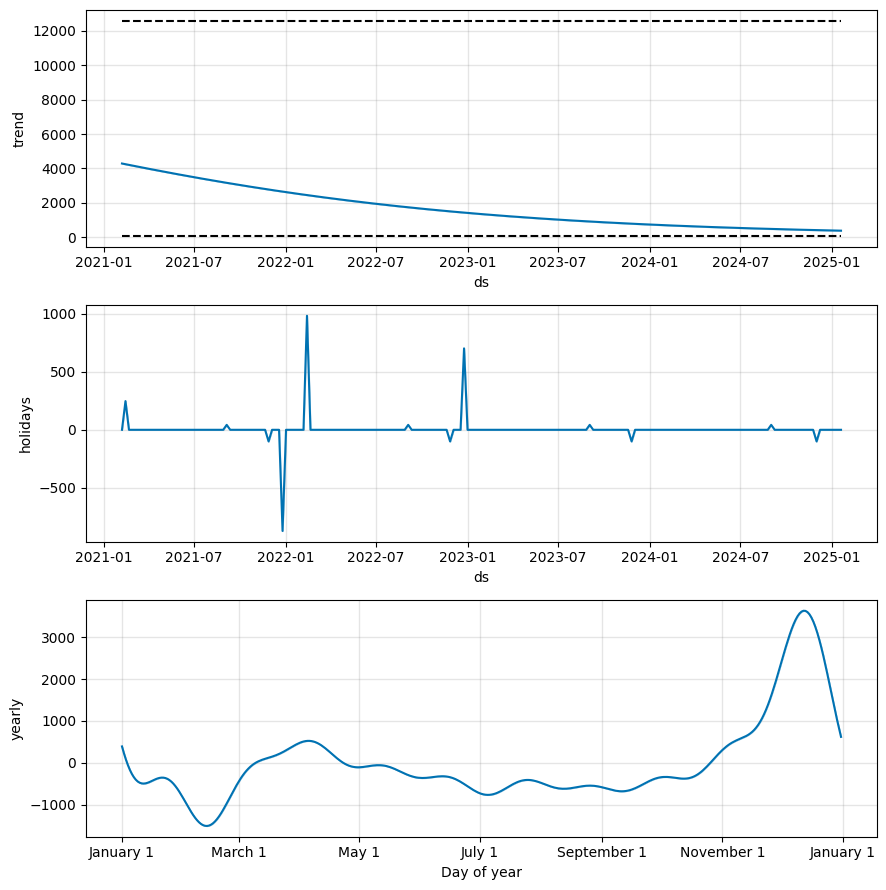

In [18]:
# 2. Resample to Weekly (W) to get weekly aggregate of orders
# We switch to weekly so holidays are not absorbed by quarterly seasonality
weekly_series = df_orders.resample('W', on='event_timestamp').size().reset_index()

# Prophet requires the date column to be named 'ds' and the target variable to be 'y'
weekly_series.rename(columns={'event_timestamp': 'ds', 0: 'y'}, inplace=True)

# Remove timezone information as Prophet does not support timezone-aware datetimes
weekly_series['ds'] = weekly_series['ds'].dt.tz_localize(None)

# FIX: Drop the final row because it is likely an incomplete week (e.g., ends on a Tuesday)
# This prevents the model from learning an artificial massive drop at the end of the training data
weekly_series = weekly_series.iloc[:-1].copy()

# Add cap and floor columns for logistic growth
# We set the floor to a small baseline to represent the remaining userbase, preventing negative predictions
baseline_orders = weekly_series['y'].mean() * 0.03
weekly_series['floor'] = baseline_orders

# The cap needs to be set to a reasonable upper bound. Here we use 2 times the historical max.
max_orders = weekly_series['y'].max()
weekly_series['cap'] = max_orders * 2

# Define the retail holidays for Fingerhut's specific inventory (2021-2024)
holidays_data = {
    'holiday': [
        'Black Friday', 'Black Friday', 'Black Friday', 'Black Friday',
        'Cyber Monday', 'Cyber Monday', 'Cyber Monday', 'Cyber Monday',
        'Christmas', 'Christmas', 'Christmas', 'Christmas',
        'Valentines', 'Valentines', 'Valentines', 'Valentines',
        'Labor Day', 'Labor Day', 'Labor Day', 'Labor Day'
    ],
    'ds': pd.to_datetime([
        '2021-11-26', '2022-11-25', '2023-11-24', '2024-11-29', # Black Friday
        '2021-11-29', '2022-11-28', '2023-11-27', '2024-12-02', # Cyber Monday
        '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25', # Christmas
        '2021-02-14', '2022-02-14', '2023-02-14', '2024-02-14', # Valentines (Jewelry)
        '2021-09-06', '2022-09-05', '2023-09-04', '2024-09-02'  # Labor Day (Appliances)
    ]),
    'lower_window': -3, # Extends the holiday effect 3 days before
    'upper_window': 3   # Extends the holiday effect 3 days after to match the weekly grouping
}
retail_holidays = pd.DataFrame(holidays_data)

# 3. Fit the model using logistic growth, ADDITIVE seasonality, and retail holidays
# We forcefully set yearly_seasonality=True because our dataset is just barely under 730 days
m = Prophet(
    growth='logistic', 
    seasonality_mode='additive', 
    holidays=retail_holidays,
    yearly_seasonality=True
)
m.fit(weekly_series)

# 4. Create a forecast for 2024
# Since the latest timestamp in the training data is early 2023, we project 104 weeks (2 years) into the future
future = m.make_future_dataframe(periods=104, freq='W')

# The future dataframe also needs the cap and floor defined
future['floor'] = baseline_orders
future['cap'] = max_orders * 2

forecast = m.predict(future)

# Force any stray predictions in the confidence intervals to respect our baseline floor
forecast['yhat'] = forecast['yhat'].clip(lower=baseline_orders)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=baseline_orders)

# 5. Plot the forecast predictions
fig1 = m.plot(forecast)
plt.title('Weekly Orders Shipped: Forecast for 2024 (Additive Seasonality)')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

# 6. Plot the model components (interpreting the trend and seasonality coefficients)
fig2 = m.plot_components(forecast)
plt.show()

# Task 3

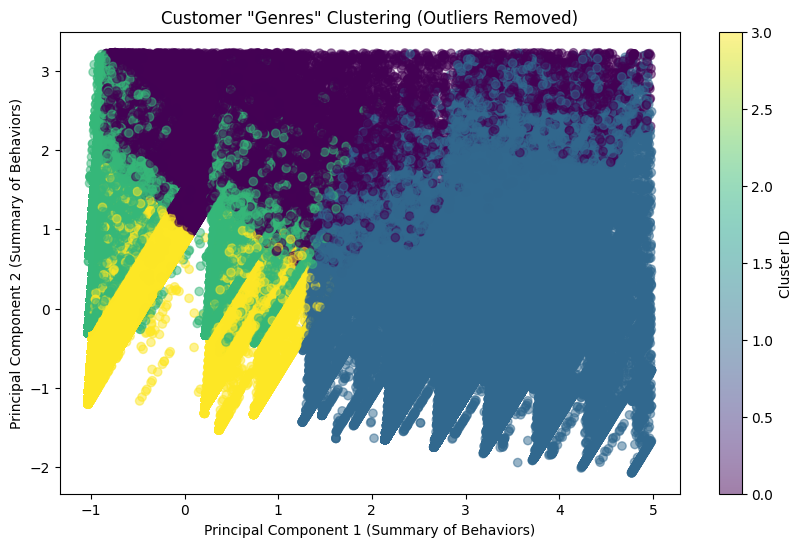

Average Stage Interactions per Cluster:
stage    Apply for Credit  Credit Account  Discover  Downpayment  \
cluster                                                            
0                   28.13            0.37      0.95         0.32   
1                    5.54            1.02      0.60         2.29   
2                    4.78            0.05      1.03         0.01   
3                    5.60            0.05      0.00         0.01   

stage    First Purchase  Order Shipped  
cluster                                 
0                113.83           0.11  
1                 38.27           0.97  
2                 13.68           0.00  
3                 14.48           0.00  


In [6]:
import pandas as pd
import io
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Load the provided key mapping into a DataFrame
key_csv_data = """event_name,journey_id,event_definition_id,milestone_number,stage
application_phone_approved,1,15,1,Apply for Credit
application_phone_declined,1,16,,Apply for Credit
application_phone_pending,1,17,,Apply for Credit
application_web_approved,1,12,1,Apply for Credit
application_web_declined,1,13,,Apply for Credit
application_web_pending,1,14,,Apply for Credit
application_web_submit,1,3,,Apply for Credit
application_web_view,1,19,,Apply for Credit
account_activitation,1,29,3,Credit Account
account_fraud_review,1,37,,Credit Account
campaign_click,1,2,,Discover
customer_requested_catalog_digital,1,9,,Discover
fingerhut_university,1,10,,Discover
pre_application_3rd_party_affiliates,1,22,,Discover
site_registration,1,23,,Discover
account_downpaymentcleared,1,27,5,Downpayment
account_downpaymentreceived,1,26,,Downpayment
place_downpayment,1,8,4,Downpayment
place_downpayment_phone,1,25,4,Downpayment
add_to_cart,1,11,,First Purchase
begin_checkout,1,6,,First Purchase
browse_products,1,4,,First Purchase
place_order_phone,1,18,2,First Purchase
place_order_web,1,7,2,First Purchase
view_cart,1,5,,First Purchase
order_shipped,1,28,6,Order Shipped
catalog_email_experian,1,20,,Prospecting
catalog_mail,1,21,,Prospecting"""

df_key = pd.read_csv(io.StringIO(key_csv_data))

# 2. Merge the stages onto your clean tracking data
# df_clean is the dataframe after removing duplicates in Task 2
df_merged = df_clean.merge(df_key[['event_name', 'stage']], on='event_name', how='left')

# 3. Create a feature matrix: count of interactions per stage for each customer
customer_profiles = pd.crosstab(df_merged['customer_id'], df_merged['stage'])

# 4. Scale the features so stages with high volume do not dominate the distance metrics
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profiles)

# 5. Apply K-Means Clustering (starting with 4 clusters as a guess)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_profiles['cluster'] = kmeans.fit_predict(scaled_features)

import numpy as np
from scipy import stats

# 6. Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 7. Identify outliers using Z-scores on the PCA features
# Calculate the Z-score for each principal component
z_scores = np.abs(stats.zscore(pca_features))

# Define a threshold (e.g., 3 standard deviations from the mean)
threshold = 3

# Create a boolean mask to keep only the rows where both PCA components are within the threshold
# This filters out extreme outliers that stretch the plot
mask = (z_scores[:, 0] < threshold) & (z_scores[:, 1] < threshold)

# Apply the mask to our features and cluster labels
clean_pca_features = pca_features[mask]
clean_clusters = customer_profiles['cluster'].values[mask]

# 8. Plot the cleaned clusters
plt.figure(figsize=(10, 6))
plt.scatter(clean_pca_features[:, 0], clean_pca_features[:, 1], c=clean_clusters, cmap='viridis', alpha=0.5)
plt.title('Customer "Genres" Clustering (Outliers Removed)')
plt.xlabel('Principal Component 1 (Summary of Behaviors)')
plt.ylabel('Principal Component 2 (Summary of Behaviors)')
plt.colorbar(label='Cluster ID')
plt.show()

# 9. Output the average stage interactions per cluster to interpret the "genres"
cluster_summary = customer_profiles.groupby('cluster').mean()
print("Average Stage Interactions per Cluster:")
print(cluster_summary.round(2))